## Imports

In [1]:
import pandas as pd
import numpy as np
import datetime
import time
import os

# Machine Learning Imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Plotting (Optional)
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

## Config

In [2]:
# --- Configuration ---
WEATHER_DATA_PATH = "synthetic_weather_data.csv"
OPERATIONS_DATA_PATH = "synthetic_operations_log.csv"
# !!! Start date used for weather generation !!!
SIMULATION_START_DATE = '2023-01-01'

# --- Feature Engineering Parameters ---
FORECAST_HORIZON_HOURS = 48 # How many hours of weather forecast to use as features
TIME_WINDOWS = [6, 12, 24, 48] # Summary windows for weather features (in hours)
TARGET_COLUMN = 'total_weather_delay_hrs'

## Loading

In [3]:
# --- Load Data ---
print("Loading data...")
weather_df = pd.read_csv(WEATHER_DATA_PATH, index_col=0, parse_dates=True)
ops_df = pd.read_csv(OPERATIONS_DATA_PATH)
print(f"Loaded {len(weather_df)} weather records and {len(ops_df)} operations records.")


Loading data...
Loaded 2137 weather records and 1453 operations records.


## EDA

In [4]:
# --- Config for EDA ---
# Set plot style for the notebook session
plt.style.use('seaborn-v0_8-whitegrid')
# Ensure plots appear inline in Jupyter
%matplotlib inline
# Adjust default figure size for better readability in notebooks
plt.rcParams['figure.figsize'] = (10, 6)


In [5]:
print("\n--- Weather Data Preview ---")
weather_df.info()
display(weather_df.head()) # Use display() in notebooks
display(weather_df.describe())


--- Weather Data Preview ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2137 entries, 2023-01-01 00:00:00 to 2023-03-31 00:00:00
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   state               2137 non-null   object 
 1   wind_speed_knots    2137 non-null   float64
 2   visibility_nm       2137 non-null   float64
 3   precipitation_mmhr  2137 non-null   float64
 4   wave_height_m       2137 non-null   float64
 5   wind_direction_deg  2137 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 116.9+ KB


,state,wind_speed_knots,visibility_nm,precipitation_mmhr,wave_height_m,wind_direction_deg
2023-01-01 00:00:00,Clear,6.007984,9.420700,0.0,1.084276,270
2023-01-01 01:00:00,Clear,2.884593,9.910041,0.0,0.570414,270
2023-01-01 02:00:00,Clear,8.966290,9.789549,0.0,1.228085,270
2023-01-01 03:00:00,Clear,11.355572,9.219863,0.0,0.576015,315
2023-01-01 04:00:00,Clear,2.613552,9.352561,0.0,0.692487,0


,wind_speed_knots,visibility_nm,precipitation_mmhr,wave_height_m,wind_direction_deg
count,2137.000000,2137.000000,2137.000000,2137.000000,2137.000000
mean,6.041119,8.128945,0.438477,0.948563,204.342536
std,5.574338,2.822711,1.824982,0.709277,97.272859
min,0.019109,0.003883,0.000000,0.123407,0.000000
25%,2.594754,8.238463,0.000000,0.518804,135.000000
50%,4.471721,9.325521,0.000000,0.741423,225.000000
75%,7.483184,9.736858,0.000000,1.134938,270.000000
max,49.158647,9.999654,29.216808,7.562986,315.000000


In [6]:
print("\n--- Operations Data Preview ---")
ops_df.info()
display(ops_df.head())
key_ops_metrics = ['teu', 'total_time_hrs', 'berth_time_hrs', 'berth_wait_time_hrs',
                'weather_delay_entry_hrs', 'weather_delay_berthing_hrs',
                'cargo_ops_weather_delay_hrs', 'total_weather_delay_hrs']
key_ops_metrics_present = [col for col in key_ops_metrics if col in ops_df.columns]
if key_ops_metrics_present:
        display(ops_df[key_ops_metrics_present].describe())
else:
        print("Key operational metrics not found.")



--- Operations Data Preview ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1453 entries, 0 to 1452
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   vessel_id                    1453 non-null   object 
 1   type                         1453 non-null   object 
 2   teu                          1453 non-null   float64
 3   arrival_time                 1453 non-null   float64
 4   entry_permit_time            1453 non-null   float64
 5   weather_delay_entry_hrs      1453 non-null   float64
 6   berth_wait_time_hrs          1453 non-null   float64
 7   weather_delay_berthing_hrs   1453 non-null   float64
 8   berth_start_time             1453 non-null   float64
 9   berth_end_time               1453 non-null   float64
 10  cargo_ops_weather_delay_hrs  1453 non-null   float64
 11  departure_time               1453 non-null   float64
 12  total_time_hrs               1453 non-null 

,vessel_id,type,teu,arrival_time,entry_permit_time,weather_delay_entry_hrs,berth_wait_time_hrs,weather_delay_berthing_hrs,berth_start_time,berth_end_time,cargo_ops_weather_delay_hrs,departure_time,total_time_hrs,berth_time_hrs,total_weather_delay_hrs
0,V_9,Container_Panamax,4638.830383,8.980155,8.980155,0.0,0.0,0.0,10.480155,56.868459,0.0,58.368459,49.388304,46.388304,0.0
1,V_14,Container_Panamax,4480.132440,11.899020,11.899020,0.0,0.0,0.0,13.399020,58.200344,0.0,59.700344,47.801324,44.801324,0.0
2,V_17,Container_Panamax,4453.212136,14.588116,14.588116,0.0,0.0,0.0,16.088116,60.620237,0.0,62.120237,47.532121,44.532121,0.0
3,V_11,Container_Panamax,5579.161724,10.211932,10.211932,0.0,0.0,0.0,11.711932,67.503549,0.0,69.003549,58.791617,55.791617,0.0
4,V_25,Container_Panamax,4459.929114,24.008551,24.008551,0.0,0.0,0.0,25.508551,70.107842,0.0,71.607842,47.599291,44.599291,0.0


,teu,total_time_hrs,berth_time_hrs,berth_wait_time_hrs,weather_delay_entry_hrs,weather_delay_berthing_hrs,cargo_ops_weather_delay_hrs,total_weather_delay_hrs
count,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000
mean,11918.617135,122.594380,119.445635,0.000088,0.140399,0.008259,0.259463,0.408121
std,5290.248043,52.991191,52.985718,0.002112,0.551331,0.090533,0.509674,0.758326
min,3262.918256,35.629183,32.629183,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8546.098995,88.622197,85.622197,0.000000,0.000000,0.000000,0.000000,0.000000
50%,10406.361617,107.921854,104.482177,0.000000,0.000000,0.000000,0.000000,0.000000
75%,17280.156523,175.947797,172.895546,0.000000,0.000000,0.000000,0.000000,1.000000
max,22640.565765,230.405658,227.405658,0.056409,6.000000,1.000000,2.000000,6.000000


### Weather Data EDA - Distributions and States


--- 1. Analyzing Weather Data (`weather_df`) ---

Weather Time Series Check:
Index is monotonic increasing: True
Inferred Frequency: h
Cannot automatically check for missing timestamps (frequency not 'H').

Plotting Weather Variable Distributions...


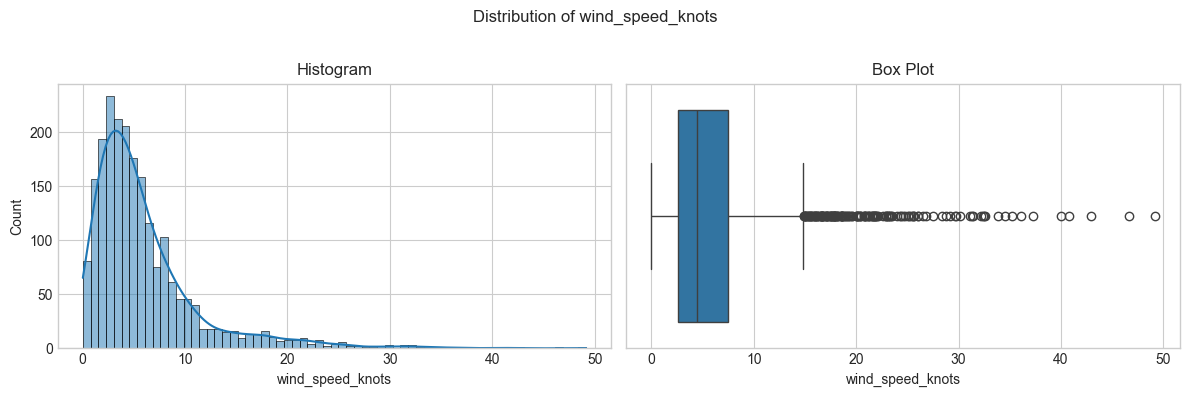

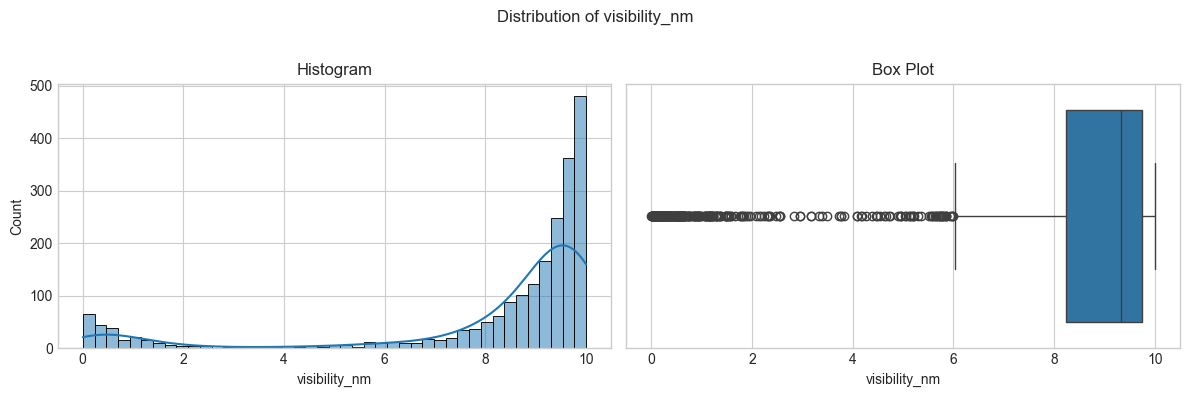

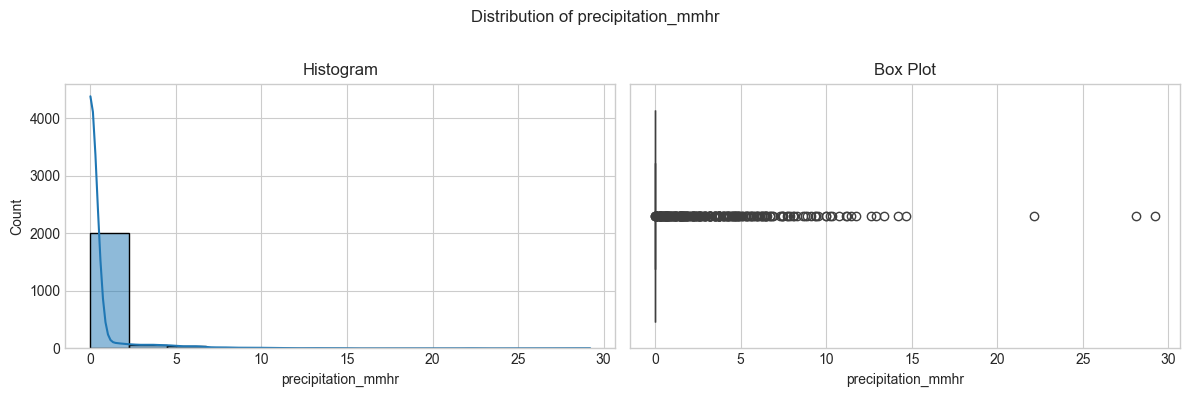

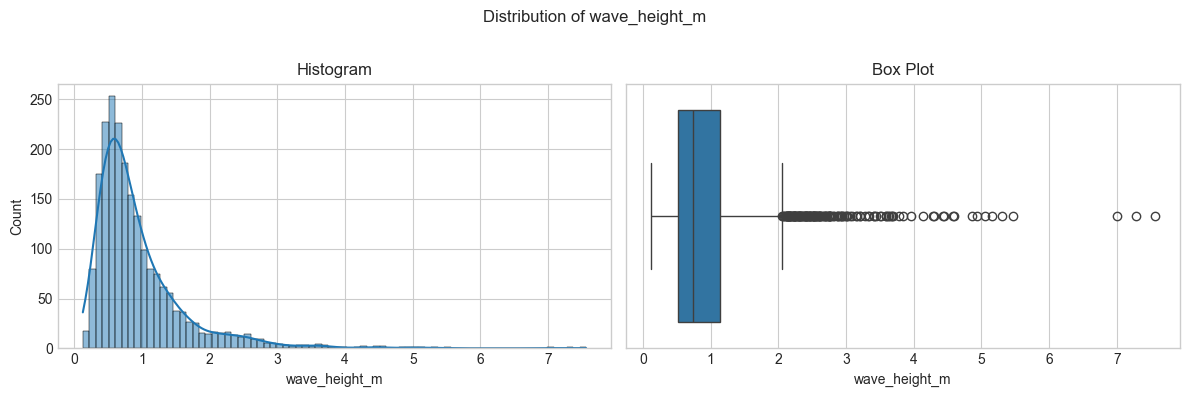

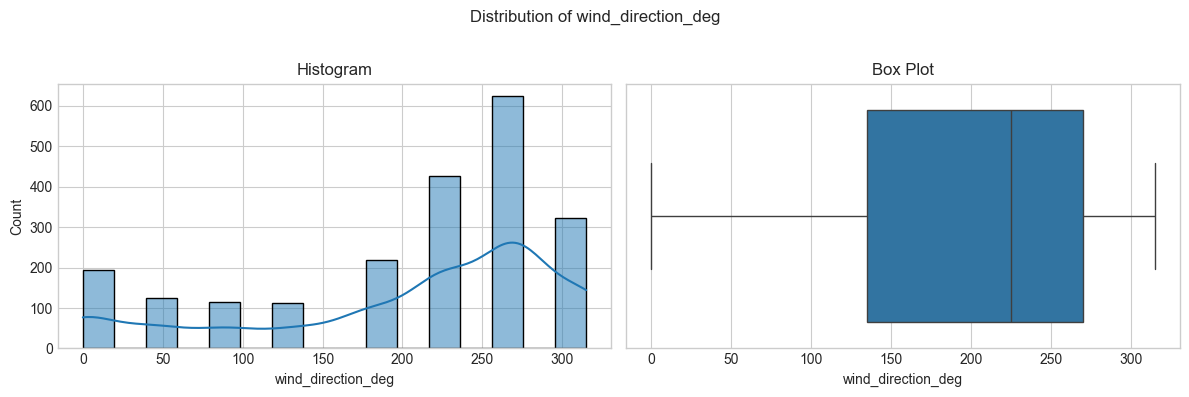


Analyzing Weather States...


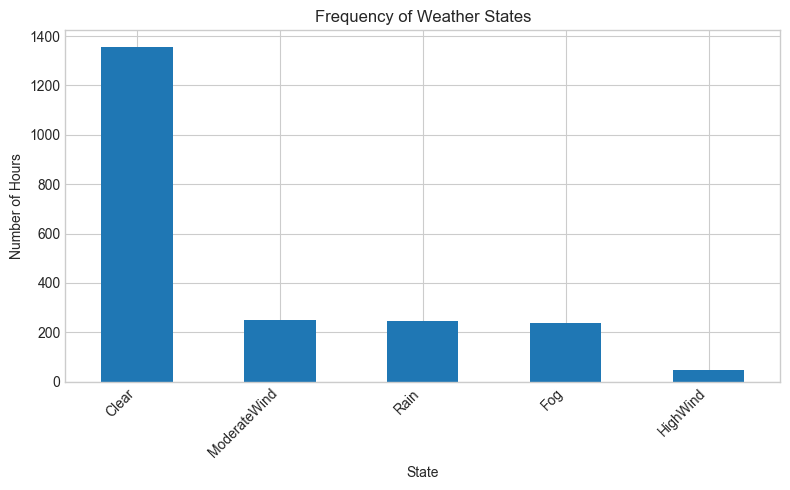


Weather State Counts:
state
Clear           1355
ModerateWind     251
Rain             246
Fog              239
HighWind          46
Name: count, dtype: int64


In [7]:
if 'weather_df' not in locals():
    print("Weather data not loaded. Skipping Weather EDA.")
else:
    print("\n--- 1. Analyzing Weather Data (`weather_df`) ---")

    # Time Series Properties
    print("\nWeather Time Series Check:")
    print(f"Index is monotonic increasing: {weather_df.index.is_monotonic_increasing}")
    inferred_freq = pd.infer_freq(weather_df.index) # type: ignore
    print(f"Inferred Frequency: {inferred_freq}")
    if inferred_freq == 'H':
        expected_range = pd.date_range(start=weather_df.index.min(), end=weather_df.index.max(), freq='H')
        missing_timestamps = expected_range.difference(weather_df.index)
        print(f"Number of missing hourly timestamps: {len(missing_timestamps)}")
    else:
        print("Cannot automatically check for missing timestamps (frequency not 'H').")


    # Distribution of Numerical Weather Variables
    print("\nPlotting Weather Variable Distributions...")
    numerical_weather_cols = weather_df.select_dtypes(include=np.number).columns
    for col in numerical_weather_cols:
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        fig.suptitle(f'Distribution of {col}')
        sns.histplot(weather_df[col], kde=True, ax=axes[0]) # type: ignore
        axes[0].set_title('Histogram')
        sns.boxplot(x=weather_df[col], ax=axes[1])
        axes[1].set_title('Box Plot')
        plt.tight_layout(rect=(0, 0, 1, 0.96)) # Adjust layout
        plt.show() # Display the plot inline

    # Weather State Analysis (if 'state' column exists)
    if 'state' in weather_df.columns:
        print("\nAnalyzing Weather States...")
        fig, ax = plt.subplots(figsize=(8, 5))
        state_counts = weather_df['state'].value_counts()
        state_counts.plot(kind='bar', ax=ax)
        ax.set_title('Frequency of Weather States')
        ax.set_ylabel('Number of Hours')
        ax.set_xlabel('State')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
        print("\nWeather State Counts:")
        print(state_counts)
    else:
        print("\n'state' column not found in weather data.")

### Weather Data EDA - Correlations and Time Series Plots


Plotting Weather Variable Correlation Matrix...


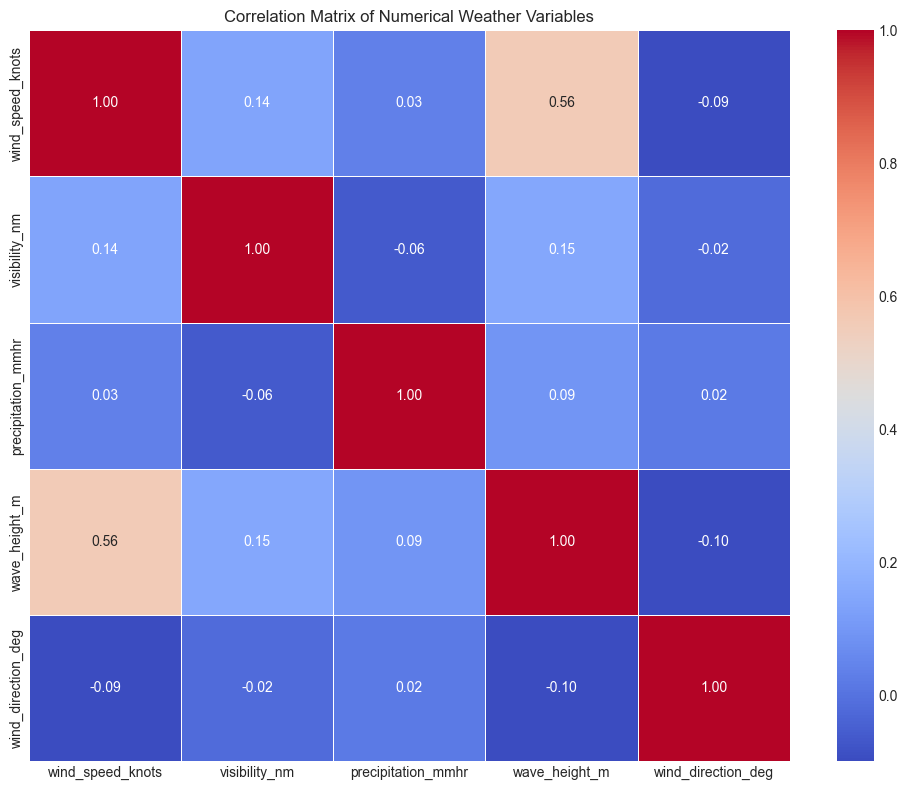


Plotting Weather Variables Over Time (Sample)...


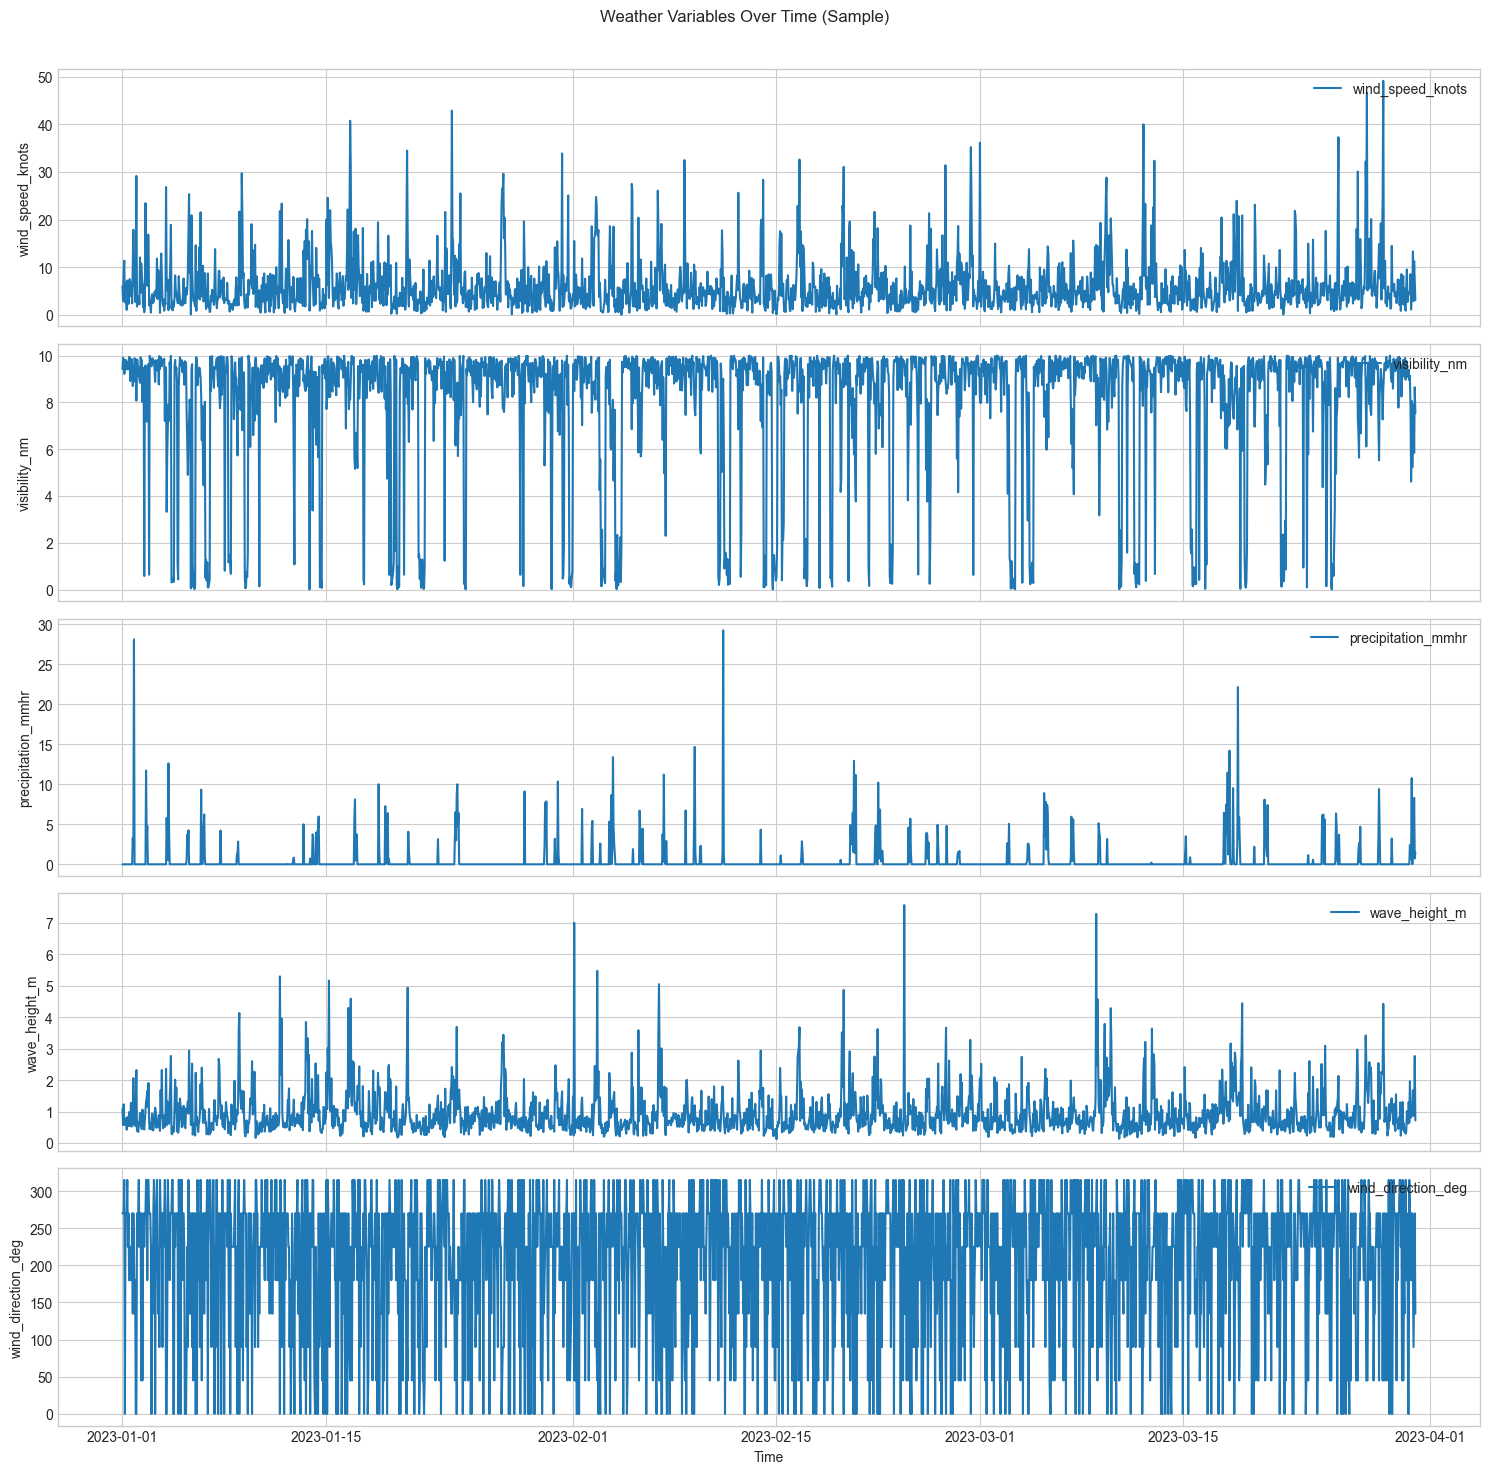

In [8]:
if 'weather_df' not in locals():
    print("Weather data not loaded. Skipping Weather EDA.")
else:
    # Correlation Matrix for Numerical Weather Variables
    print("\nPlotting Weather Variable Correlation Matrix...")
    numerical_weather_cols = weather_df.select_dtypes(include=np.number).columns
    if len(numerical_weather_cols) > 1:
         correlation_matrix = weather_df[numerical_weather_cols].corr()
         fig, ax = plt.subplots(figsize=(10, 8))
         sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, ax=ax)
         ax.set_title('Correlation Matrix of Numerical Weather Variables')
         plt.tight_layout()
         plt.show()
    else:
         print("  Not enough numerical columns for correlation matrix.")

    # Time Series Plots (Plot subset for clarity if data is very long)
    print("\nPlotting Weather Variables Over Time (Sample)...")
    plot_subset_days = 90 # Plot approx 3 months
    inferred_freq = pd.infer_freq(weather_df.index) # Re-check freq # type: ignore
    subset_end_index = min(len(weather_df)-1, int(plot_subset_days * 24 / (1 if inferred_freq=='H' else 1))) # Adjust if not hourly
    weather_subset = weather_df.iloc[:subset_end_index]

    cols_to_plot = numerical_weather_cols # Plot all numerical
    if len(cols_to_plot) > 0:
         n_plots = len(cols_to_plot)
         fig, axes = plt.subplots(n_plots, 1, figsize=(15, n_plots * 3), sharex=True)
         if n_plots == 1: axes = [axes] # Make it iterable if only one plot
         fig.suptitle('Weather Variables Over Time (Sample)')
         for i, col in enumerate(cols_to_plot):
             axes[i].plot(weather_subset.index, weather_subset[col], label=col)
             axes[i].set_ylabel(col)
             axes[i].legend(loc='upper right')
             axes[i].grid(True)
         axes[-1].set_xlabel("Time")
         plt.tight_layout(rect=(0, 0, 1, 0.97)) # Adjust layout
         plt.show()
    else:
         print("  No numerical columns found to plot time series.")

### Operations Data EDA - Distributions


--- 2. Analyzing Operations Data (`ops_df`) ---

Plotting Operational Metric Distributions...


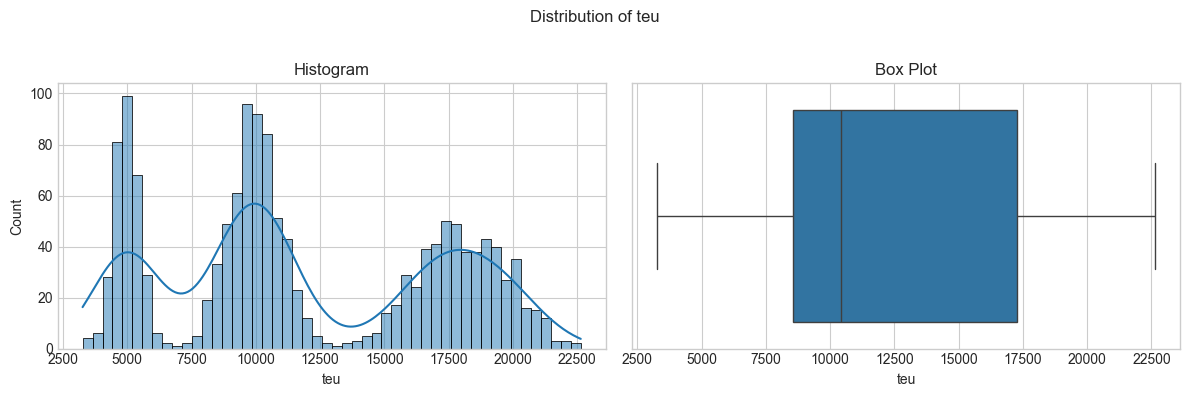

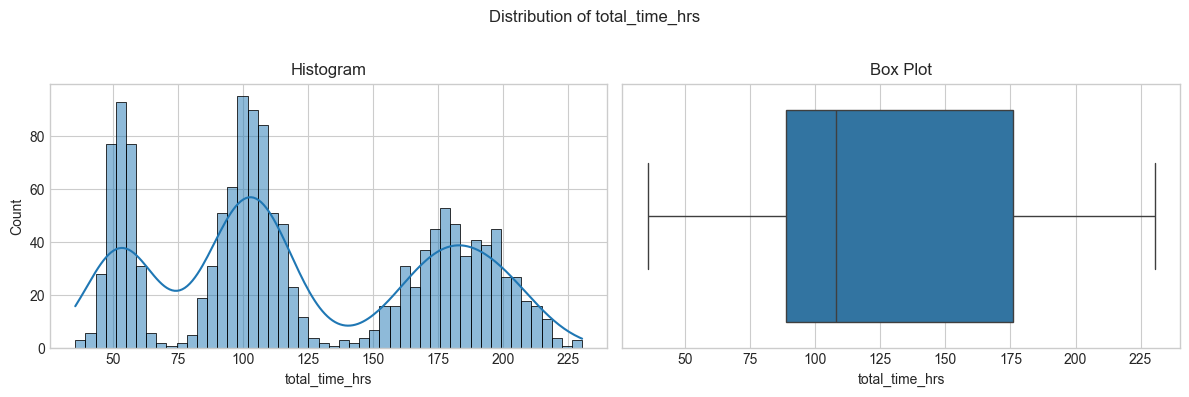

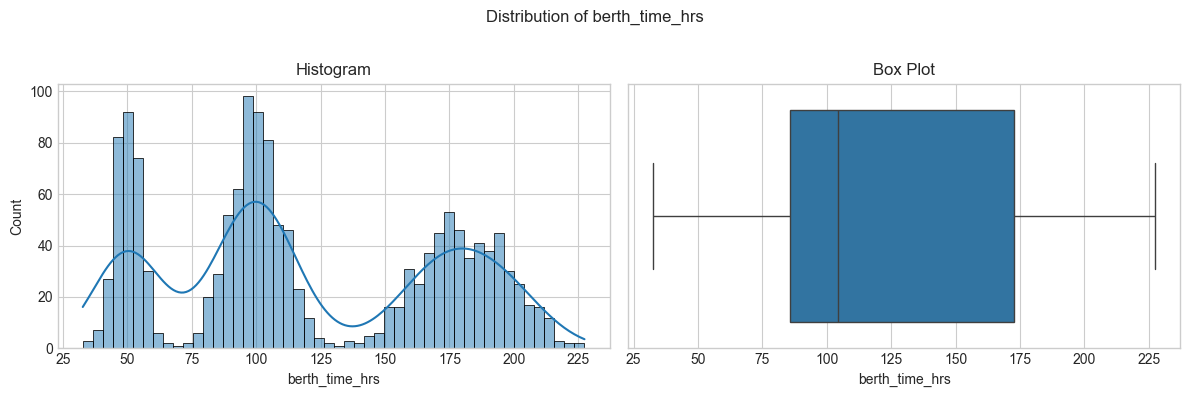

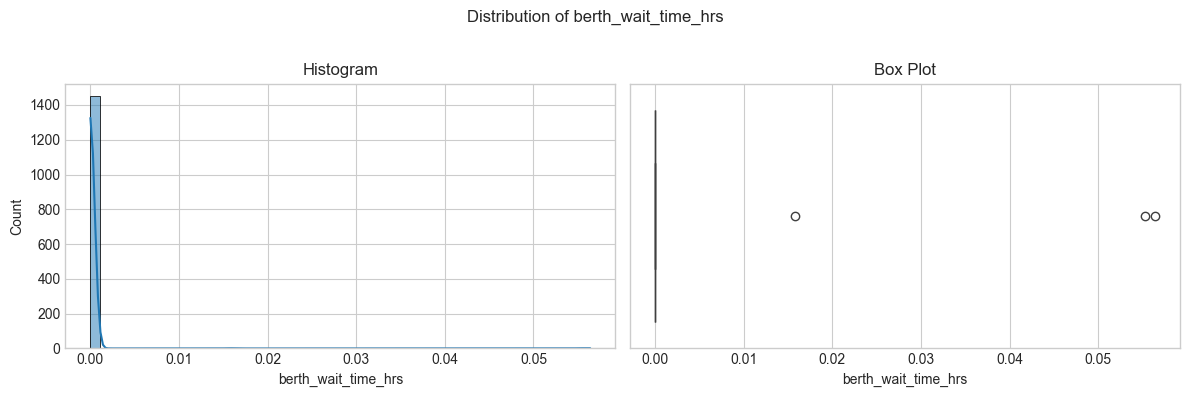

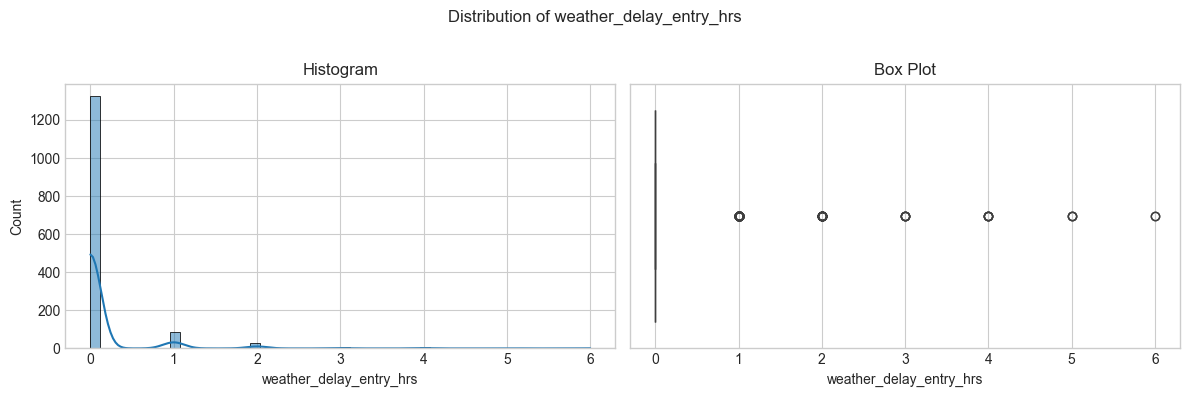

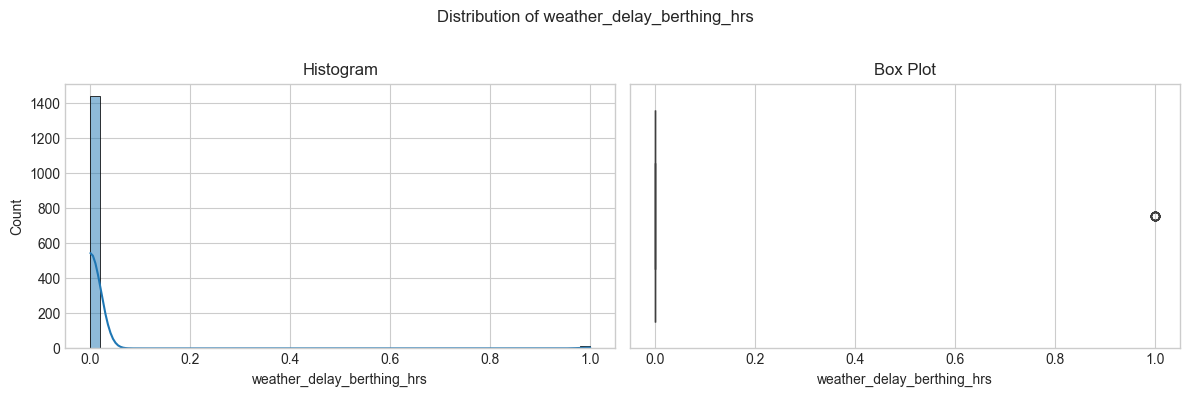

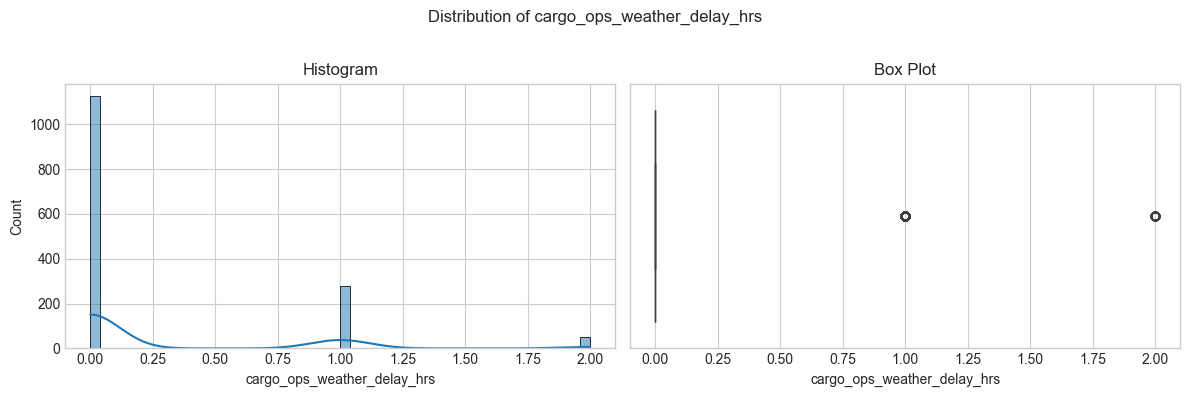

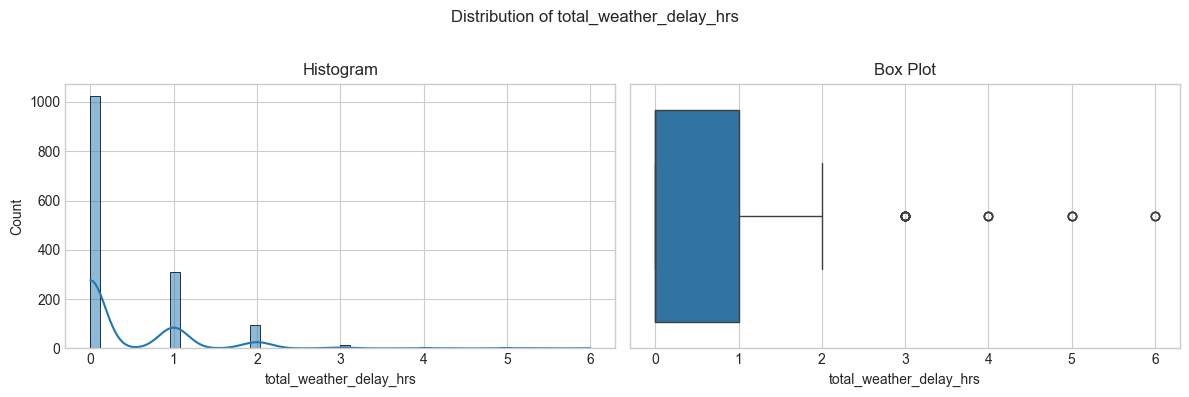


Plotting Vessel Type Distribution...


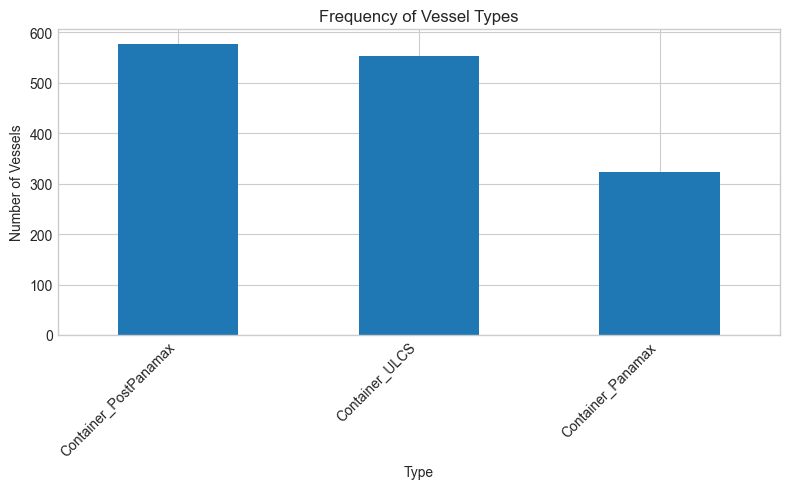


Vessel Type Counts:
type
Container_PostPanamax    577
Container_ULCS           553
Container_Panamax        323
Name: count, dtype: int64


In [9]:
if 'ops_df' not in locals():
    print("Operations data not loaded. Skipping Operations EDA.")
else:
    print("\n--- 2. Analyzing Operations Data (`ops_df`) ---")

    # Distribution of Key Numerical Operational Metrics
    print("\nPlotting Operational Metric Distributions...")
    key_ops_metrics = ['teu', 'total_time_hrs', 'berth_time_hrs', 'berth_wait_time_hrs',
                   'weather_delay_entry_hrs', 'weather_delay_berthing_hrs',
                   'cargo_ops_weather_delay_hrs', 'total_weather_delay_hrs']
    key_ops_metrics_present = [col for col in key_ops_metrics if col in ops_df.columns]

    for col in key_ops_metrics_present:
        # Skip delay columns if they are potentially all zero
        if 'delay' in col and ops_df[col].max() <= 0: # Use <= 0 to be safe
            print(f"  Skipping plot for '{col}' as values are likely all zero or negative.")
            continue
        if ops_df[col].isnull().all():
            print(f"  Skipping plot for '{col}' as all values are missing.")
            continue

        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        fig.suptitle(f'Distribution of {col}')
        sns.histplot(ops_df[col].dropna(), kde=True, ax=axes[0], bins=50) # type: ignore
        axes[0].set_title('Histogram')
        sns.boxplot(x=ops_df[col].dropna(), ax=axes[1])
        axes[1].set_title('Box Plot')
        plt.tight_layout(rect=(0, 0, 1, 0.96))
        plt.show()

    # Distribution of Categorical Features (e.g., Vessel Type)
    if 'type' in ops_df.columns:
        print("\nPlotting Vessel Type Distribution...")
        fig, ax = plt.subplots(figsize=(8, 5))
        type_counts = ops_df['type'].value_counts()
        type_counts.plot(kind='bar', ax=ax)
        ax.set_title('Frequency of Vessel Types')
        ax.set_ylabel('Number of Vessels')
        ax.set_xlabel('Type')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
        print("\nVessel Type Counts:")
        print(type_counts)
    else:
        print("\n'type' column not found in operations data.")

### Relating Weather and Operations


--- 3. Analyzing Relationships Between Weather and Operations ---
  Adding arrival timestamps to operations data...
  Analyzing delays based on weather state at arrival...


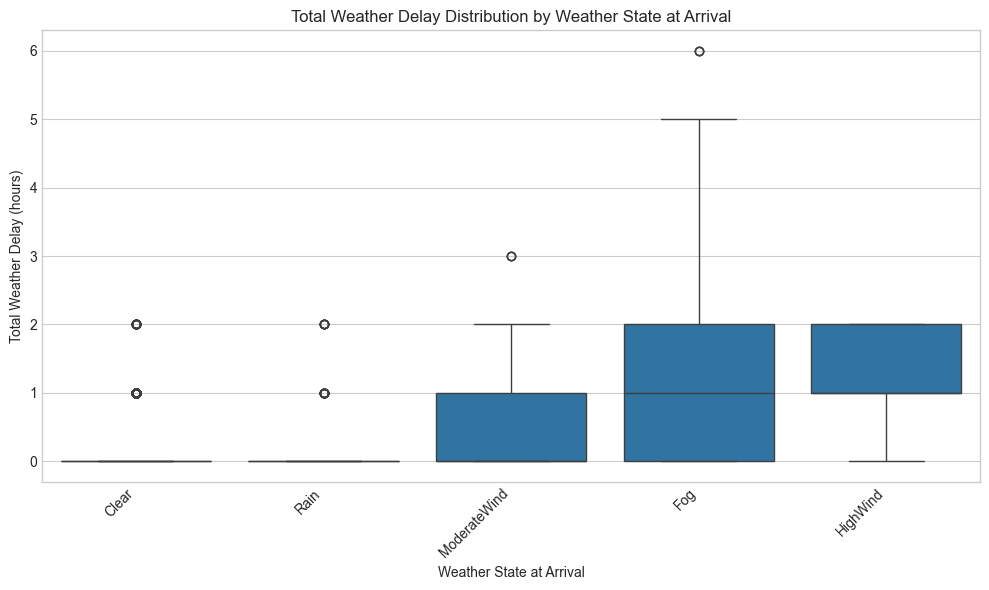


  Plotting aggregated daily delays vs. adverse weather hours...


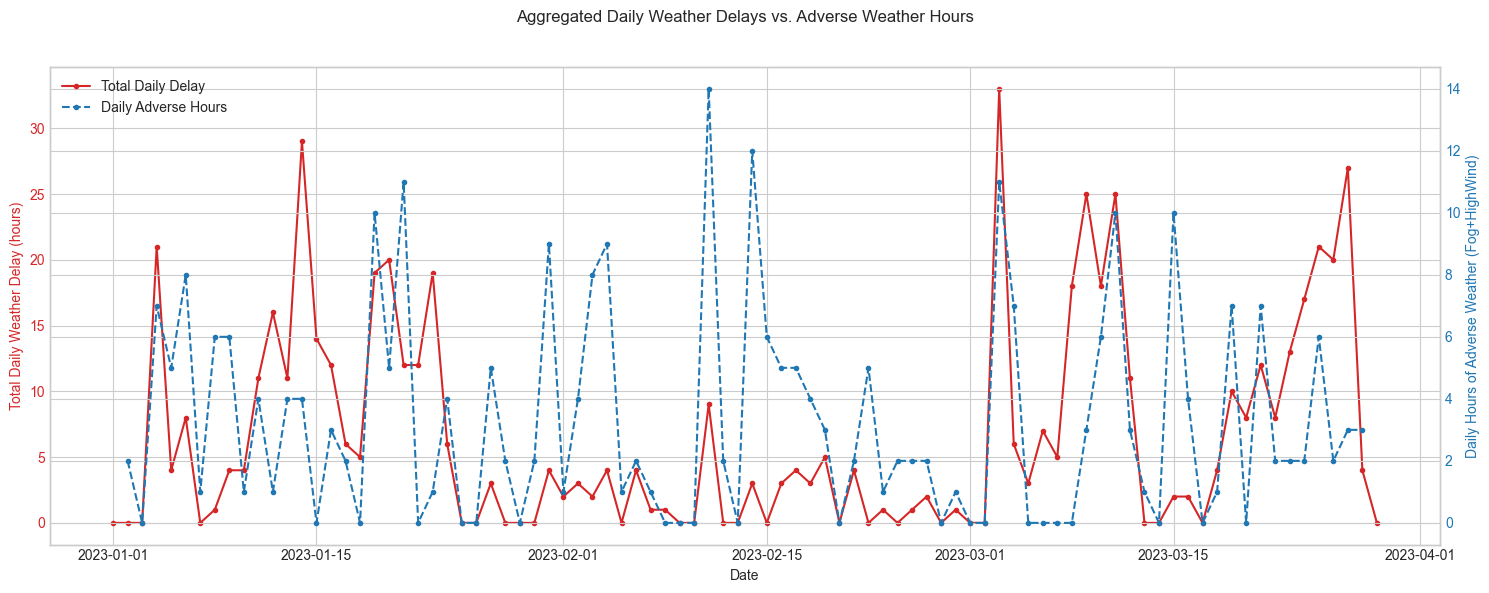


--- EDA Finished ---


In [10]:
print("\n--- 3. Analyzing Relationships Between Weather and Operations ---")

# Add arrival timestamp to ops_df for alignment (ensure it's not added multiple times)
if 'arrival_timestamp' not in ops_df.columns:
    print("  Adding arrival timestamps to operations data...")
    base_datetime = pd.to_datetime(SIMULATION_START_DATE)
    ops_df['arrival_timestamp'] = ops_df['arrival_time'].apply(lambda h: base_datetime + pd.Timedelta(hours=h))
else:
    # Ensure it's datetime if it already exists
        ops_df['arrival_timestamp'] = pd.to_datetime(ops_df['arrival_timestamp'])

# Compare delays during different weather conditions at arrival
if 'state' in weather_df.columns and 'total_weather_delay_hrs' in ops_df.columns:
    print("  Analyzing delays based on weather state at arrival...")
    # Use merge_asof for efficient time-based joining
    ops_df_sorted = ops_df.sort_values('arrival_timestamp')
    # Ensure weather_df index is datetime and sorted
    if not isinstance(weather_df.index, pd.DatetimeIndex):
            weather_df.index = pd.to_datetime(weather_df.index)
    weather_df = weather_df.sort_index()

    weather_df_with_ts = weather_df.reset_index().rename(columns={'index': 'timestamp'})

    
    # Merge weather state at arrival time
    ops_with_arrival_weather = pd.merge_asof(
        ops_df_sorted,
        weather_df_with_ts[['timestamp', 'state']],
        left_on='arrival_timestamp',
        right_on='timestamp',
        direction='nearest'
    )
    
    # Plot delays grouped by arrival weather state
    if ops_with_arrival_weather['total_weather_delay_hrs'].max() > 0:
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.boxplot(data=ops_with_arrival_weather, x='state', y='total_weather_delay_hrs', ax=ax)
        ax.set_title('Total Weather Delay Distribution by Weather State at Arrival')
        ax.set_xlabel('Weather State at Arrival')
        ax.set_ylabel('Total Weather Delay (hours)')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    else:
        print("  Skipping Delay vs Arrival State plot (no delays recorded).")
    
else:  
    print("  Skipping analysis of delays by arrival weather state (required columns missing: 'state' in weather or 'total_weather_delay_hrs' in ops).")



# Aggregate Delays and Adverse Weather over Time (e.g., Daily)
print("\n  Plotting aggregated daily delays vs. adverse weather hours...")
target_col = 'total_weather_delay_hrs'
if target_col in ops_df.columns and ops_df[target_col].max() > 0:
    # Ensure arrival_timestamp is the index for resampling
    if not isinstance(ops_df.index, pd.DatetimeIndex):
        if 'arrival_timestamp' in ops_df.columns:
                ops_df_temp = ops_df.set_index('arrival_timestamp')
        else:
                print("  Cannot resample delays, 'arrival_timestamp' index missing.")
                ops_df_temp = None
    else:
        ops_df_temp = ops_df

    if ops_df_temp is not None:
            daily_delays = ops_df_temp[target_col].resample('D').sum()

            # Calculate daily hours of adverse weather
            adverse_states = []
            daily_adverse_hours = pd.Series(dtype=float) # Initialize empty series

            if 'state' in weather_df.columns:
                daily_adverse_hours = weather_df[weather_df['state'].isin(['Fog', 'HighWind'])]
                daily_adverse_hours = daily_adverse_hours.resample('D').size()
                adverse_states = ['Fog', 'HighWind']
            else: # Use thresholds as proxy
                daily_adverse_hours = weather_df[
                    (weather_df['visibility_nm'] < 1.0) | (weather_df['wind_speed_knots'] > 30)
                ].resample('D').size()
                adverse_states = ['LowVis or HighWind']

            if not daily_delays.empty and not daily_adverse_hours.empty:
                fig, ax1 = plt.subplots(figsize=(15, 6))

                color = 'tab:red'
                ax1.set_xlabel('Date')
                ax1.set_ylabel('Total Daily Weather Delay (hours)', color=color)
                ax1.plot(daily_delays.index, daily_delays, color=color, label='Total Daily Delay', marker='.', linestyle='-')
                ax1.tick_params(axis='y', labelcolor=color)
                ax1.grid(True, axis='y')

                ax2 = ax1.twinx()
                color = 'tab:blue'
                ax2.set_ylabel(f'Daily Hours of Adverse Weather ({"+".join(adverse_states)})', color=color)
                ax2.plot(daily_adverse_hours.index, daily_adverse_hours, color=color, label='Daily Adverse Hours', marker='.', linestyle='--')
                ax2.tick_params(axis='y', labelcolor=color)

                # Add shared legend
                lines, labels = ax1.get_legend_handles_labels()
                lines2, labels2 = ax2.get_legend_handles_labels()
                ax2.legend(lines + lines2, labels + labels2, loc='upper left')

                fig.suptitle('Aggregated Daily Weather Delays vs. Adverse Weather Hours')
                plt.tight_layout(rect=(0, 0, 1, 0.96))
                plt.show()
            else:
                print("  Skipping daily aggregation plot (no delays or adverse weather hours found after resampling).")
    else:
            print("  Skipping daily aggregation plot due to missing timestamp index.")

else:
    print("  Skipping daily aggregation plot (no delays recorded or target column missing).")


print("\n--- EDA Finished ---")

## Feature Engineering

In [11]:
# --- Feature Engineering ---
print("Performing feature engineering...")
base_datetime = pd.to_datetime(SIMULATION_START_DATE)

# 1. Convert arrival_time (hours) to actual timestamp
ops_df['arrival_timestamp'] = ops_df['arrival_time'].apply(lambda h: base_datetime + pd.Timedelta(hours=h))

# 2. Add basic time features from arrival_timestamp
ops_df['arrival_hour'] = ops_df['arrival_timestamp'].dt.hour
ops_df['arrival_dayofweek'] = ops_df['arrival_timestamp'].dt.dayofweek
ops_df['arrival_month'] = ops_df['arrival_timestamp'].dt.month


Performing feature engineering...


In [12]:
# 3. Function to extract future weather features for a given arrival time
def get_weather_features(arrival_ts, weather_data, horizon_h, windows):
    """
    Extracts summary statistics of weather variables over future time windows.
    """
    forecast_start_time = arrival_ts
    forecast_end_time = forecast_start_time + pd.Timedelta(hours=horizon_h)

    # Select the relevant forecast period from weather data
    # Ensure index is sorted for efficient lookup
    if not weather_data.index.is_monotonic_increasing:
         weather_data = weather_data.sort_index()

    # Use slicing which is efficient on DatetimeIndex
    forecast_data = weather_data.loc[forecast_start_time : forecast_end_time]

    if forecast_data.empty:
        # Handle cases where arrival is too late for the forecast horizon
        # Return NaNs or default values - NaNs are better to see issues
        cols = [f'{var}_{agg}_{w}h'
                for w in windows
                for var in ['wind_speed_knots', 'visibility_nm', 'wave_height_m'] # Add other relevant vars
                for agg in ['mean', 'max', 'min', 'std']]
        return pd.Series(index=cols, dtype=np.float64)

    features = {}
    weather_vars_to_summarize = ['wind_speed_knots', 'visibility_nm', 'wave_height_m'] # Add others if needed

    for window_h in windows:
        window_end_time = forecast_start_time + pd.Timedelta(hours=window_h)
        window_data = forecast_data.loc[forecast_start_time : window_end_time]

        if window_data.empty: continue # Skip if window is empty

        for var in weather_vars_to_summarize:
            if var not in window_data.columns: continue # Skip if weather var is missing

            series = window_data[var]
            features[f'{var}_mean_{window_h}h'] = series.mean()
            features[f'{var}_max_{window_h}h'] = series.max()
            # Min visibility is important, min wind/wave might be less so, but include for now
            features[f'{var}_min_{window_h}h'] = series.min()
            features[f'{var}_std_{window_h}h'] = series.std() # Captures variability

    # Example: Add count of 'Fog' or 'HighWind' states if 'state' column exists
    if 'state' in forecast_data.columns:
         for window_h in windows:
             window_end_time = forecast_start_time + pd.Timedelta(hours=window_h)
             window_data = forecast_data.loc[forecast_start_time : window_end_time]
             if window_data.empty: continue
             for state in ['Fog', 'HighWind']: # Add other critical states
                 features[f'{state}_hours_{window_h}h'] = (window_data['state'] == state).sum()


    return pd.Series(features)


In [13]:
# Apply the function - This can be slow for large datasets!
print(f"Extracting weather features for {len(ops_df)} vessels (horizon={FORECAST_HORIZON_HOURS}h)...")
start_feature_time = time.time()
weather_feature_list = ops_df['arrival_timestamp'].apply(
    get_weather_features,
    args=(weather_df, FORECAST_HORIZON_HOURS, TIME_WINDOWS)
)
end_feature_time = time.time()
print(f"Weather feature extraction took {end_feature_time - start_feature_time:.2f} seconds.")

# Join features back to ops_df
model_data = pd.concat([ops_df, weather_feature_list], axis=1)

Extracting weather features for 1453 vessels (horizon=48h)...
Weather feature extraction took 4.93 seconds.


## Preprocessing

In [14]:
# --- Data Cleaning ---
print("Cleaning data...")
# Drop rows where weather features couldn't be calculated (e.g., arrivals too close to end of weather data)
initial_rows = len(model_data)
model_data.dropna(subset=weather_feature_list.columns, inplace=True) # Drop rows missing weather features
model_data.dropna(subset=[TARGET_COLUMN], inplace=True) # Ensure target is not NaN
# Impute NaNs in STD columns (if window had only 1 data point, std is NaN) - use 0
std_cols = [col for col in weather_feature_list.columns if '_std_' in col]
model_data[std_cols] = model_data[std_cols].fillna(0)

# Optional: Check for other NaNs and decide on imputation strategy if needed
# print(model_data.isnull().sum())

final_rows = len(model_data)
print(f"Dropped {initial_rows - final_rows} rows due to missing features/target.")
if final_rows == 0:
    print("Error: No data remaining after cleaning. Check weather data coverage and feature extraction.")
    exit()

Cleaning data...
Dropped 0 rows due to missing features/target.


In [15]:
# --- Define Features (X) and Target (y) ---
categorical_features = ['type', 'arrival_hour', 'arrival_dayofweek', 'arrival_month']
# Ensure all numerical features are included
numerical_features = ['teu'] + list(weather_feature_list.columns)

# Remove constant columns if any (e.g., if a state never occurred)
for col in numerical_features[:]: # Iterate over a copy
    if col in model_data.columns and model_data[col].nunique() <= 1:
        print(f"Warning: Removing constant or near-constant feature: {col}")
        numerical_features.remove(col)


X = model_data[categorical_features + numerical_features]
y = model_data[TARGET_COLUMN]

print(f"Features selected: {list(X.columns)}")
print(f"Target selected: {TARGET_COLUMN}")

Features selected: ['type', 'arrival_hour', 'arrival_dayofweek', 'arrival_month', 'teu', 'wind_speed_knots_mean_6h', 'wind_speed_knots_max_6h', 'wind_speed_knots_min_6h', 'wind_speed_knots_std_6h', 'visibility_nm_mean_6h', 'visibility_nm_max_6h', 'visibility_nm_min_6h', 'visibility_nm_std_6h', 'wave_height_m_mean_6h', 'wave_height_m_max_6h', 'wave_height_m_min_6h', 'wave_height_m_std_6h', 'wind_speed_knots_mean_12h', 'wind_speed_knots_max_12h', 'wind_speed_knots_min_12h', 'wind_speed_knots_std_12h', 'visibility_nm_mean_12h', 'visibility_nm_max_12h', 'visibility_nm_min_12h', 'visibility_nm_std_12h', 'wave_height_m_mean_12h', 'wave_height_m_max_12h', 'wave_height_m_min_12h', 'wave_height_m_std_12h', 'wind_speed_knots_mean_24h', 'wind_speed_knots_max_24h', 'wind_speed_knots_min_24h', 'wind_speed_knots_std_24h', 'visibility_nm_mean_24h', 'visibility_nm_max_24h', 'visibility_nm_min_24h', 'visibility_nm_std_24h', 'wave_height_m_mean_24h', 'wave_height_m_max_24h', 'wave_height_m_min_24h', 'wa

In [16]:
print(X)

                       type  arrival_hour  arrival_dayofweek  arrival_month  \
0         Container_Panamax             8                  6              1   
1         Container_Panamax            11                  6              1   
2         Container_Panamax            14                  6              1   
3         Container_Panamax            10                  6              1   
4         Container_Panamax             0                  0              1   
...                     ...           ...                ...            ...   
1448  Container_PostPanamax            13                  0              3   
1449      Container_Panamax            15                  2              3   
1450         Container_ULCS             2                  4              3   
1451         Container_ULCS            15                  4              3   
1452  Container_PostPanamax            10                  0              3   

               teu  wind_speed_knots_mean_6h  wind_

In [17]:
# --- Train-Test Split ---
print("Splitting data into training and testing sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")


Splitting data into training and testing sets...
Training set size: 1162, Test set size: 291


In [18]:
# --- Preprocessing Pipeline ---
print("Setting up preprocessing pipeline...")
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))]) # handle_unknown='ignore' is important


Setting up preprocessing pipeline...


## Setup

In [19]:
# Create the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

# --- Define Models ---
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1), # n_jobs=-1 uses all cores
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1, objective='reg:squarederror') # Use squared error objective
}

## Training and Evaluation

### Functions

In [20]:
def save_model(pipeline, model_name):
    """
    Save the trained model to a file.
    """
    os.makedirs('models', exist_ok=True) # Ensure the directory exists
    model_filename = f"models/{model_name.replace(' ', '_').lower()}_pipeline.joblib"
    try:
        joblib.dump(pipeline, model_filename)
        print(f"Successfully saved trained pipeline for {model_name} to {model_filename}")
    except Exception as e:
        print(f"Error saving pipeline for {model_name}: {e}")

In [21]:
def train_and_evaluate_model(model_name, model, X_train, y_train, X_test, y_test):
    """
    Train and evaluate a given model.
    """
    start_train_time = time.time()
    print(f"\n--- Training {model_name} ---")

    # Create full pipeline with preprocessing and model
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', model)])

    # Train
    pipeline.fit(X_train, y_train)

    # Save the trained model    
    save_model(pipeline, model_name) 

    # Predict
    y_pred = pipeline.predict(X_test)

    # Ensure predictions are non-negative (delay cannot be negative)
    # y_pred = np.maximum(0, y_pred)

    # Evaluate
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    end_train_time = time.time()
    duration = end_train_time - start_train_time

    results = {'RMSE': rmse, 'MAE': mae, 'R2': r2, 'Training Time (s)': duration}
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R2 Score: {r2:.4f}")
    print(f"Training/Evaluation Time: {duration:.2f} seconds")

    return pipeline, results

### Running

In [22]:
# --- Train, Predict, and Evaluate Models ---
results = {}
trained_pipelines = {}

print("Training and evaluating models...")
for name, model in models.items():
    trained_pipelines[name], results[name] = train_and_evaluate_model(name, model, X_train, y_train, X_test, y_test)


Training and evaluating models...

--- Training Linear Regression ---
Successfully saved trained pipeline for Linear Regression to models/linear_regression_pipeline.joblib
RMSE: 0.7325
MAE: 0.4624
R2 Score: 0.2490
Training/Evaluation Time: 0.04 seconds

--- Training Random Forest ---
Successfully saved trained pipeline for Random Forest to models/random_forest_pipeline.joblib
RMSE: 0.6049
MAE: 0.2863
R2 Score: 0.4879
Training/Evaluation Time: 0.70 seconds

--- Training XGBoost ---
Successfully saved trained pipeline for XGBoost to models/xgboost_pipeline.joblib
RMSE: 0.5568
MAE: 0.2587
R2 Score: 0.5661
Training/Evaluation Time: 0.36 seconds


### Comparison


--- Model Comparison ---
                       RMSE       MAE        R2  Training Time (s)
XGBoost            0.556798  0.258659  0.566107           0.358922
Random Forest      0.604929  0.286254  0.487850           0.700030
Linear Regression  0.732542  0.462375  0.248979           0.039322

--- Feature Importances for Random Forest ---
Saved feature importance plot to Random Forest_feature_importance.png

--- Feature Importances for XGBoost ---
Saved feature importance plot to XGBoost_feature_importance.png


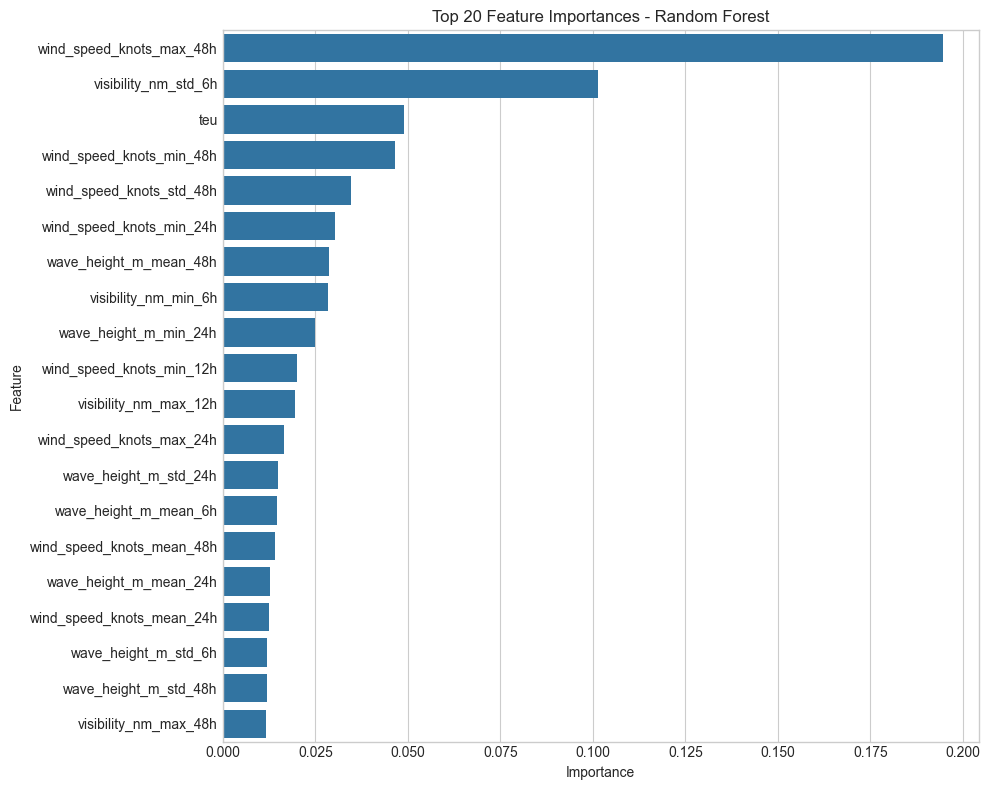

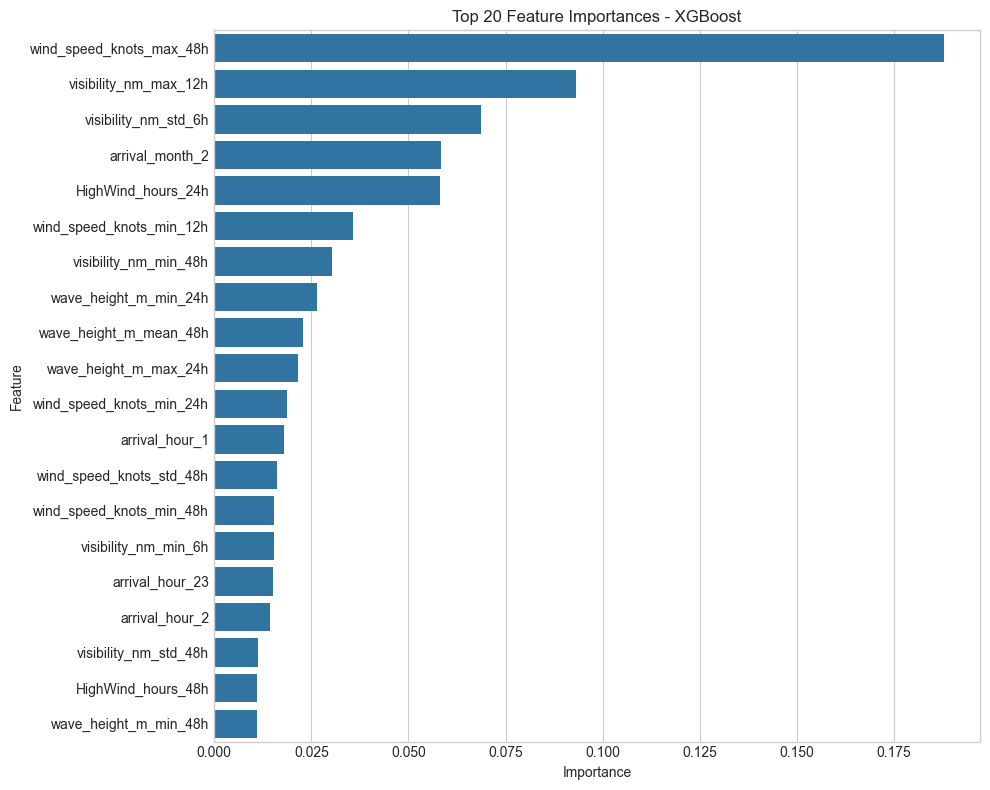

In [23]:
# --- Compare Models ---
print("\n--- Model Comparison ---")
results_df = pd.DataFrame(results).T # Transpose for better readability
results_df = results_df.sort_values(by='RMSE', ascending=True) # Sort by RMSE (lower is better)
print(results_df)

# --- Optional: Feature Importance (for tree-based models) ---
for name in ["Random Forest", "XGBoost"]:
    if name in trained_pipelines:
        print(f"\n--- Feature Importances for {name} ---")
        try:
            # Need to get feature names after one-hot encoding
            feature_names_raw = numerical_features + \
                list(trained_pipelines[name].named_steps['preprocessor']
                     .named_transformers_['cat']
                     .named_steps['onehot']
                     .get_feature_names_out(categorical_features))

            importances = trained_pipelines[name].named_steps['regressor'].feature_importances_

            # Handle cases where number of features doesn't match importances length
            if len(feature_names_raw) != len(importances):
                 print(f"Warning: Mismatch between feature names ({len(feature_names_raw)}) and importances ({len(importances)}) for {name}. Skipping plot.")
                 continue


            feature_importance_df = pd.DataFrame({'Feature': feature_names_raw, 'Importance': importances})
            feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(20) # Show top 20

            plt.figure(figsize=(10, 8))
            sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
            plt.title(f'Top 20 Feature Importances - {name}')
            plt.tight_layout()
            plt.savefig(f"{name}_feature_importance.png") # Save the plot
            print(f"Saved feature importance plot to {name}_feature_importance.png")
            # plt.show() # Uncomment to display plots directly

        except AttributeError:
            print(f"Could not retrieve feature importances for {name}.")
        except Exception as e:
            print(f"An error occurred during feature importance plotting for {name}: {e}")


### Error Analysis

In [24]:
def analyze_model_errors(model_name, pipeline, X_test, y_test):
    """
    Performs error analysis on a trained regression pipeline.

    Args:
        pipeline: Fitted scikit-learn pipeline object.
        X_test: Original test features DataFrame (unprocessed).
        y_test: True target values for the test set.
        model_name (str): Name of the model for plot titles.
    """
    print(f"\n--- Error Analysis for {model_name} ---")

    # 1. Get Predictions
    y_pred = pipeline.predict(X_test)
    # y_pred = np.maximum(0, y_pred) # Ensure non-negative delays

    # 2. Calculate Errors (Residuals)
    residuals = y_test - y_pred

    # --- Visualizations ---
    plt.style.use('seaborn-v0_8-whitegrid') # Use a clean style
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'Error Analysis: {model_name}', fontsize=16, y=1.02) # Adjust title position

    # 3. Predicted vs. Actual
    ax = axes[0, 0]
    max_val = max(y_test.max(), y_pred.max()) * 1.1
    min_val = min(y_test.min(), y_pred.min()) * 0.9 if min(y_test.min(), y_pred.min()) < 0 else 0 # Handle potential negative preds before clipping
    sns.scatterplot(x=y_test, y=y_pred, ax=ax, alpha=0.6)
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Ideal (y=x)') # Ideal line
    ax.set_xlabel("Actual Delay (hours)")
    ax.set_ylabel("Predicted Delay (hours)")
    ax.set_title("Predicted vs. Actual Values")
    ax.set_xlim(left=min_val, right=max_val)
    ax.set_ylim(bottom=min_val, top=max_val)
    ax.legend()
    ax.grid(True)


    # 4. Residual Distribution
    ax = axes[0, 1]
    sns.histplot(residuals, kde=True, ax=ax)
    ax.set_xlabel("Residual (Actual - Predicted)")
    ax.set_ylabel("Frequency")
    ax.set_title("Residual Distribution")
    ax.axvline(0, color='r', linestyle='--') # Line at zero error
    ax.grid(True)


    # 5. Residuals vs. Predicted
    ax = axes[1, 0]
    sns.scatterplot(x=y_pred, y=residuals, ax=ax, alpha=0.6)
    ax.axhline(0, color='r', linestyle='--', lw=2) # Line at zero error
    ax.set_xlabel("Predicted Delay (hours)")
    ax.set_ylabel("Residual (Actual - Predicted)")
    ax.set_title("Residuals vs. Predicted Values")
    ax.grid(True)

    # 6. Residuals vs. a Key Feature (Example: 'teu')
    ax = axes[1, 1]
    key_feature = 'teu' # Choose an important feature to plot against
    if key_feature in X_test.columns:
         sns.scatterplot(x=X_test[key_feature], y=residuals, ax=ax, alpha=0.6)
         ax.axhline(0, color='r', linestyle='--', lw=2)
         ax.set_xlabel(f"Feature: {key_feature}")
         ax.set_ylabel("Residual (Actual - Predicted)")
         ax.set_title(f"Residuals vs. {key_feature}")
         ax.grid(True)
    else:
         ax.text(0.5, 0.5, f"Feature '{key_feature}' not found in X_test.", ha='center', va='center')
         ax.set_title(f"Residuals vs. {key_feature} (Not Found)")


    plt.tight_layout(rect=(0.0, 0.0, 1.0, 0.98)) # Adjust layout to prevent title overlap
    plt.savefig(f"{model_name.replace(' ', '_').lower()}_error_analysis.png")
    print(f"Saved error analysis plot to {model_name.replace(' ', '_').lower()}_error_analysis.png")
    # plt.show() # Uncomment to display plots

    # 7. (Optional) Identify Largest Errors
    error_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'Residual': residuals})
    error_df['Abs_Residual'] = error_df['Residual'].abs()
    largest_errors = error_df.sort_values(by='Abs_Residual', ascending=False).head(10)

    print("\nTop 10 Largest Absolute Errors:")
    print(largest_errors)

    # You could join this back with X_test on index to see the features for the worst predictions
    # print(X_test.loc[largest_errors.index])

#### XGBoost


--- Error Analysis for XGBoost ---
Saved error analysis plot to xgboost_error_analysis.png

Top 10 Largest Absolute Errors:
      Actual  Predicted  Residual  Abs_Residual
1073     6.0   1.518597  4.481403      4.481403
1030     6.0   1.850699  4.149301      4.149301
271      2.0   0.100987  1.899013      1.899013
123      0.0   1.850534 -1.850534      1.850534
1246     3.0   1.177951  1.822049      1.822049
1391     2.0   0.210606  1.789394      1.789394
705      0.0   1.537233 -1.537233      1.537233
1338     2.0   0.499399  1.500601      1.500601
755      0.0   1.489323 -1.489323      1.489323
787      0.0   1.445005 -1.445005      1.445005


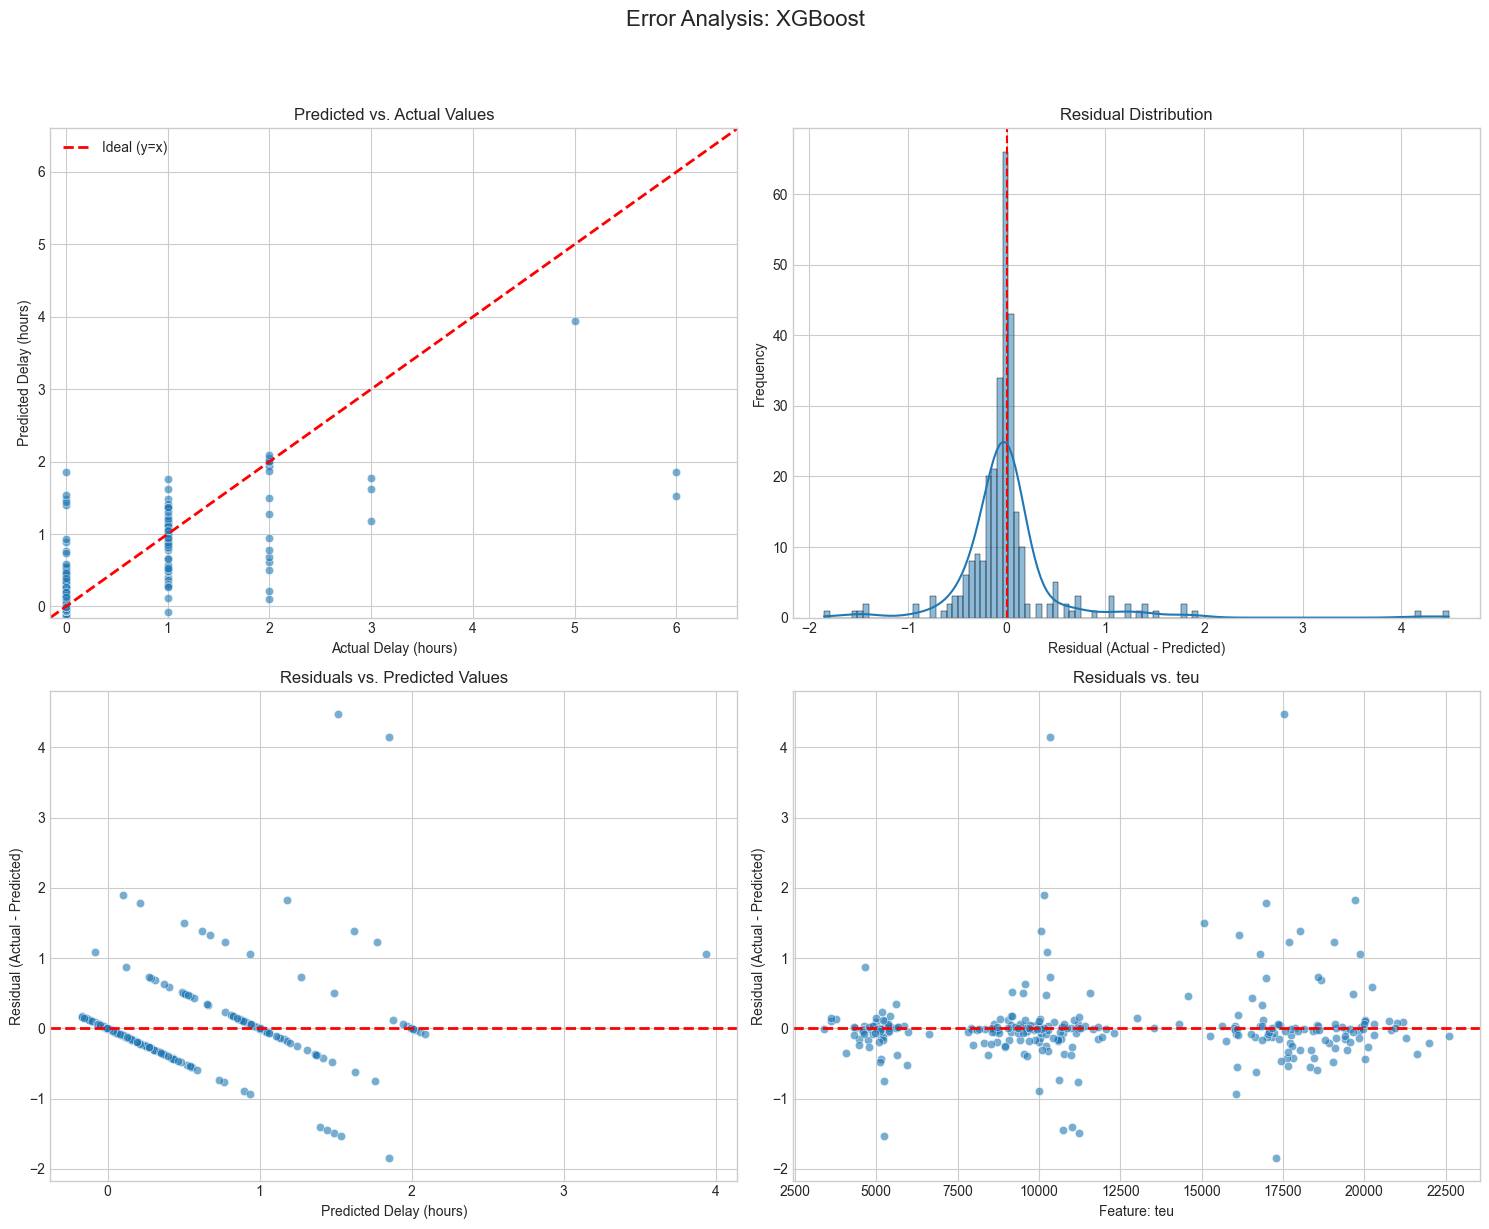

In [25]:
analyze_model_errors("XGBoost", trained_pipelines["XGBoost"], X_test, y_test)
